In [1]:
using SparseArrays
using LaTeXStrings
include("meshgenerator.jl")

boundary_nodes

In [1]:
H0(x) = 2x^3-3x^2+1
H1(x) = 3x^2-2x^3
H0t(x) = x^3-2x^2+x
H1t(x) = x^3-x^2

function phi_1(x)
    if x < 1/2
        return H1(2x)
    else
        return H0(2x-1)
    end
end
function phi_2(x)
    if x < 1/2
        return H1t(2x)
    else
        return H0t(2x-1)
    end
end

u_exact(x) = 4x^5-5x^4-2x^3+3x^2
u_num(x, u1, u2) = u1*phi_1(x) + u2*phi_2(x)

n = 101
x = (0:n)/n

A = [12 0; 0 4]
b = [60, 8]
u1, u2 = A \ b
println(u1)
println(u2)

# plot(x, H0t.(x), "k", lw=3, label=L"u_{num}")
plot(x, u_num.(x, u1, u2), "k", lw=3, label=L"u_{num}")
plot(x, u_exact.(x), "r--", lw=3, label=L"u_{exact}")
xlabel("x")
ylabel("y")
title("FE numerical solution, and exact for BVP (1)-(2)")
legend()
savefig("figs/uplot.pdf")

5.0
2.0


LoadError: LoadError: UndefVarError: @L_str not defined
in expression starting at In[1]:40

In [14]:
"""
    stampA, stampb = get_stamp(p, t)

Assemble local stamp for A and b, from points p[t]
Calculate area of triangle from verticies
Calculate coefficient matrix by inverting vandermonde

"""
function get_stamp(p, t)
    x1, y1 = p[t[1], :]
    x2, y2 = p[t[2], :]
    x3, y3 = p[t[3], :]

    area = x1*y2 + x2*y3 + x3*y1 - y1*x2 - y2*x3 - y3*x1
    C = inv([1 x1 y1; 1 x2 y2; 1 x3 y3])

    # A = [2. -1 -1; -1 1 0; -1 0 1]

    # Stamp
    A = zeros(3, 3)
    for i = 1:3
        A[i, i] = C[2, i]^2 + C[3, i]^2  # diagonal
        for j = 1:i-1  # off-diagonal
            A[i, j] = C[2, i] * C[2, j] + C[3, i] * C[3, j]
            A[j, i] = A[i, j]  # symmetry
        end
    end
    A *= area
    b = ones(3) * area / 3
    
    return A, b
end

get_stamp

In [3]:
"""
    u = fempoi(p, t, e)

Solve poissons equation on polygon p with elements t
homogeneous Dirichlet conditions are imposed on e: u(e) = 0
homogeneous Neumann conditions are assumed on other boundaries.

"""
function fempoi(p, t, e)
    n = size(p, 1)
    A = []
    b = zeros(n)

    # Stamping method 
    for k = 1:size(t, 1)
        sA, sb = get_stamp(p, t[k, :])

        for i=1:3, j=1:3
            push!(A, (t[k,i], t[k,j], sA[i,j]))
        end
        b[t[k, :]] += sb
    end
    A = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), n, n)
    
    # Imposing homogeneous Dirichlet conditions
    for edge in e
        A[edge, :] .= 0
        A[:, edge] .= 0
        A[edge, edge] = 1
        b[edge] = 0
    end
    # Solve PDE
    A = sparse(A) * 1.0
    A \ b
end



fempoi

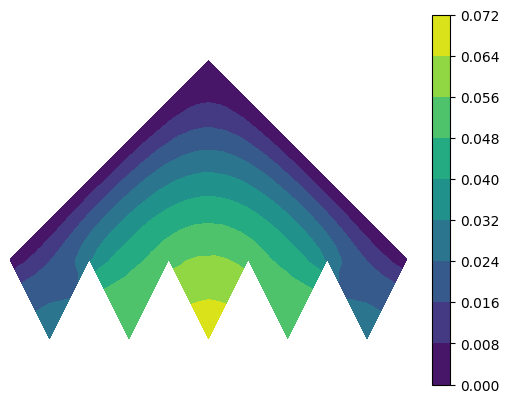

In [15]:
include("meshgenerator.jl")
function test_poisson()
    # # Square, Dirichlet left/bottom
    # pv = Float64[0 0; 1 0; 1 1; 0 1; 0 0]
    # p, t, e = pmesh(pv, 0.15, 0)
    # e = e[@. (p[e,1] < 1e-6) | (p[e,2] < 1e-6)]
    # u = fempoi(p, t, e);
    # tplot(p, t, u=u, levels=10)
    # savefig("figs/square.pdf") 
    
    # # Circle, all Dirichlet
    # n = 32; phi = 2pi*(0:n)/n
    # pv = [cos.(phi) sin.(phi)]
    # p, t, e = pmesh(pv, 2pi/n, 0)
    # u = fempoi(p, t, e)
    # tplot(p, t, u=u, levels=10)
    # savefig("figs/circle.pdf")
    
    # Generic polygon geometry, mixed Dirichlet/Neumann
    x = 0:.1:1
    y = 0.1*(-1).^(0:10)
    pv = [x y; .5 .6; 0 .1]
    p, t, e = pmesh(pv, 0.04, 0)
    e = e[@. p[e,2] > (.6 - abs(p[e,1] - 0.5) - 1e-6)]
    u = fempoi(p, t, e)
    tplot(p, t, u=u, levels=10)
    savefig("figs/generic.pdf")
    
    # # Pac-man polygon, Dirichlet on corners, Neumann elsewhere
    # pv = Float64[0 0; 1 0; .5 .5; 1 1; 0 1; 0 0]
    # p, t, e = pmesh(pv, 0.15, 0)
    # u = fempoi(p, t, 1:5)
    # tplot(p, t, u=u, levels=10)
    # savefig("figs/nepal.pdf")
end
test_poisson();

In [5]:
"""
    errors = poiconv(pv, hmax, nrefmax)

Calculates difference in solutions of fempoi()
    nref= 0,...,nrefmax-1
    nref = nrefmax
for a triangulated polygon pv, with initial edge-length hmax and refined nref times
"""
function poiconv(pv, hmax, nrefmax)
    errors = zeros(nrefmax)
    exact_sol = fempoi(pmesh(pv, hmax, nrefmax)...)
    for nref = nrefmax-1:-1:0
        p, t, e = pmesh(pv, hmax, nref)
        sol = fempoi(p, t, e)
        n = size(p)[1]
        diff = sol - exact_sol[1:n, :]
        errors[nref + 1] = maximum(abs.(diff))
    end

    return errors
end


poiconv

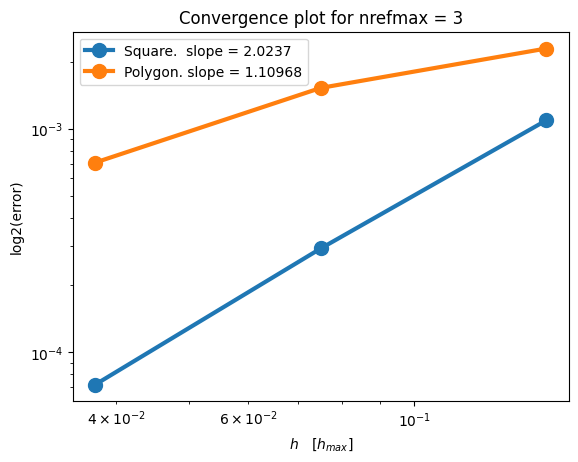

In [7]:
hmax = 0.15
nrefmax = 3
pv_square = Float64[0 0; 1 0; 1 1; 0 1; 0 0]
pv_polygon = Float64[0 0; 1 0; .5 .5; 1 1; 0 1; 0 0]

errors_square = poiconv(pv_square, hmax, nrefmax)
errors_polygon = poiconv(pv_polygon, hmax, nrefmax)
errors = [errors_square errors_polygon]

clf()
rates = @. log2(errors[end-1,:]) - log2(errors[end,:])
l = "slope = "
label = ["Square.  " * l, "Polygon. " * l] .* string.(round.(rates, digits=5))
loglog(hmax ./ (2 .^collect(0:nrefmax-1)), errors, "o-", label=label, lw=3, ms=10)
legend()
xlabel(L"h \ \ \ [h_{max}]")
ylabel("log2(error)")
title("Convergence plot for nrefmax = $(nrefmax)")
savefig("figs/convplot.pdf")